In [1]:
import os

input_dir = '/kaggle/input'
file_count = 0

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file_count < 5:
            print(os.path.join(root, file))
            file_count += 1
        else:
            break
    if file_count >= 5:
        break

/kaggle/input/data/s23_processed/bgiy6n.mpg
/kaggle/input/data/s23_processed/bwar1s.mpg
/kaggle/input/data/s23_processed/pwin7a.mpg
/kaggle/input/data/s23_processed/sgwu2p.mpg
/kaggle/input/data/s23_processed/sbbz2n.mpg


In [2]:
!pip install dlib --no-cache-dir --force-reinstall --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 78.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-20.0.0-cp310-cp310-linux_x86_64.whl size=3612023 sha256=a977f3237c83b5da422128bc9ba4ea4e22eed5790fa66dd07db62395a1578f1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-v6lcxbib/wheels/97/bc/4a/1f441cf62ce4c81ad4f83f298cef0e5ff3af0577ffb4cdff2f
Successfully built dlib


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
import os
import glob
import string
from typing import List
import dlib

In [4]:
print(dlib.__version__)

20.0.0


In [5]:
!wget https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2025-11-14 11:40:43--  https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat [following]
--2025-11-14 11:40:43--  https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: 'shape_predictor_68_face_landmarks.dat'

shape_predictor_68_ 100%[===================>] 

In [6]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

MOUTH_POINTS = list(range(48, 61))

In [7]:
def clip_mouth(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    if len(faces) == 0:
        return None

    face = faces[0]
    landmarks = predictor(gray, face)

    mouth_points = []
    for i in MOUTH_POINTS:
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        mouth_points.append((x, y))

    x_coords = [pt[0] for pt in mouth_points]
    y_coords = [pt[1] for pt in mouth_points]
    min_x = min(x_coords)
    max_x = max(x_coords)
    min_y = min(y_coords)
    max_y = max(y_coords)

    padding = 30
    min_x = max(0, min_x - padding)
    max_x = min(frame.shape[1], max_x + padding)
    min_y = max(0, min_y - padding)
    max_y = min(frame.shape[0], max_y + padding)

    mouth_region = frame[min_y:max_y, min_x:max_x]

    return mouth_region

In [9]:
def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []

    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break

        
        mouth_region = clip_mouth(frame)
        if mouth_region is not None:
            
            mouth_region = cv2.resize(mouth_region, (140, 46), interpolation=cv2.INTER_AREA)
            mouth_region = cv2.cvtColor(mouth_region, cv2.COLOR_BGR2GRAY) 
            mouth_region = tf.expand_dims(mouth_region, axis=-1)  
            frames.append(mouth_region)

    cap.release()
    frames_tensor = tf.stack(frames)  

    
    mean = tf.reduce_mean(frames_tensor)
    std = tf.math.reduce_std(tf.cast(frames_tensor, tf.float32))

    return tf.cast((frames_tensor - mean), tf.float32) / std

In [10]:
frames = load_video("/kaggle/input/data/s1_processed/bbaf2n.mpg")
print(frames.shape)

(75, 46, 140, 1)


In [11]:
frames.shape

TensorShape([75, 46, 140, 1])

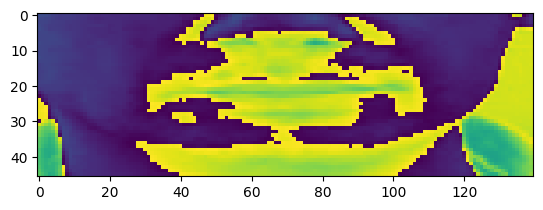

In [12]:
plt.imshow(frames[3])

In [13]:
vocab = string.ascii_lowercase + "'?! "
vocab = list(vocab)

In [14]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

In [15]:
char2num_dict = {c: char_to_num(c).numpy() for c in char_to_num.get_vocabulary()}
char2num_dict

{'': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 "'": 27,
 '?': 28,
 '!': 29,
 ' ': 30}

In [16]:
num2char_dict = {char_to_num(c).numpy():c  for c in num_to_char.get_vocabulary()}
num2char_dict

{0: '',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 27: "'",
 28: '?',
 29: '!',
 30: ' '}

In [17]:
print(char_to_num(["a", "b", "c"]), 
     num_to_char([1,2,3]))

tf.Tensor([1 2 3], shape=(3,), dtype=int64) tf.Tensor([b'a' b'b' b'c'], shape=(3,), dtype=string)


In [18]:
def load_alignment(path : str):
    with open(path, "r") as f:
        lines = f.readlines()
        
    tokens = []
    
    for line in lines:
        start, end, text = line.split()
        if text!='sil':
            tokens.append(text)
            
    chars = list(" ".join(tokens))
    
    return char_to_num(chars)

In [19]:
num = load_alignment("/kaggle/input/data/s1_processed/align/bbaf2n.align")
print(num)
print(num_to_char(num))

tf.Tensor([ 2  9 14 30  2 12 21  5 30  1 20 30  6 30 20 23 15 30 14 15 23], shape=(21,), dtype=int64)
tf.Tensor(
[b'b' b'i' b'n' b' ' b'b' b'l' b'u' b'e' b' ' b'a' b't' b' ' b'f' b' '
 b't' b'w' b'o' b' ' b'n' b'o' b'w'], shape=(21,), dtype=string)


In [20]:
def load_data(video_path : str):
    video_id = video_path.numpy().decode('UTF-8').replace("\\", "/").split("/")[-1].split(".")[0]
    align_path = f"/kaggle/input/data/s1_processed/align/{video_id}.align"
    video_path = video_path.numpy().decode('UTF-8')
    video_data = load_video(video_path)
    char_num = load_alignment(align_path)
    return video_data, char_num

In [21]:
v,c = load_data(tf.constant("/kaggle/input/data/s1_processed/bbaf2n.mpg"))

In [22]:
v.shape, c.shape

(TensorShape([75, 46, 140, 1]), TensorShape([21]))

In [23]:
def mappable_function(path: str):
    try:
        result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    except Exception as e:
        print(f"Error in {path}: {e}")
        result = None
    return result

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
videos_with_issues = [
    '/kaggle/input/data/s1_processed/lgal8n.mpg',
    '/kaggle/input/data/s1_processed/bbaf4p.mpg',
    '/kaggle/input/data/s1_processed/swwp3s.mpg',
    '/kaggle/input/data/s1_processed/lwik9s.mpg',
    '/kaggle/input/data/s1_processed/pgwr6p.mpg'
]

videos = glob.glob("/kaggle/input/data/s1_processed/*.mpg")

filtered_videos = [video for video in videos if video not in videos_with_issues]

print("Number of videos found (excluding issues):", len(filtered_videos))

Number of videos found (excluding issues): 995


In [26]:
train, test = train_test_split(filtered_videos, test_size=0.2, random_state=42)

In [27]:
data = tf.data.Dataset.from_tensor_slices(train)
data = data.shuffle(500)
data = data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
data = data.padded_batch(8, padded_shapes=([75, 46, 140, 1], [40]))
data = data.prefetch(tf.data.AUTOTUNE).cache()

val = tf.data.Dataset.from_tensor_slices(test)
val = val.shuffle(500)
val = val.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
val = val.padded_batch(8, padded_shapes=([75,  46, 140, 1], [40]))
val = val.prefetch(tf.data.AUTOTUNE).cache()

In [28]:
it = data.as_numpy_iterator()

In [29]:
f, a = it.next()
f.shape, a.shape

((8, 75, 46, 140, 1), (8, 40))

[mpeg1video @ 0x792fc008cd40] ac-tex damaged at 22 17
[mpeg1video @ 0x792fc008cd40] Warning MVs not available


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv3D, Dense, LSTM, Bidirectional, Dropout, 
                                     MaxPool3D, Activation, Reshape, SpatialDropout3D, 
                                     BatchNormalization, TimeDistributed, Flatten, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# print("Tensorflow version " + tf.__version__)
# AUTO = tf.data.experimental.AUTOTUNE

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy() 

# print("REPLICAS: ", strategy.num_replicas_in_sync)

In [31]:
def CTCLoss(y_true, y_pred):
    batch_size = tf.cast(tf.shape(y_true)[0], tf.int64)
    input_len = tf.cast(tf.shape(y_pred)[1], tf.int64)
    label_len = tf.cast(tf.shape(y_true)[1], tf.int64)

    input_len = input_len * tf.ones(shape=(batch_size, 1), dtype = tf.int64)
    label_len = label_len * tf.ones(shape=(batch_size, 1), dtype = tf.int64)
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_len, label_len) 
    
    return loss

In [32]:
model = Sequential()
model.add(Input(shape=(75, 46, 140, 1)))
model.add(Conv3D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool3D(pool_size=(1,2,2)))

model.add(Conv3D(256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool3D(pool_size=(1,2,2)))

model.add(Conv3D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool3D(pool_size=(1,2,2)))
model.add(Reshape([75, 5440]))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(char_to_num.vocabulary_size()+1, activation='softmax', kernel_initializer='he_normal'))

model.summary()

model.compile(optimizer=Adam(0.0001), loss=CTCLoss)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 64) │       442,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 75, 5440)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 512)        │    11,667,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 75, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 512)        │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75, 512)        │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75, 32)         │        16,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,690,016 (63.67 MB)

 Trainable params: 16,690,016 (63.67 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(optimizer=Adam(0.0001), loss=CTCLoss)

In [34]:
def schedular(epoch, lr):
    if epoch<100:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [35]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset
        self.it = self.dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.it.next()
        
        if data[0].shape[0] < 8:
            self.it = self.dataset.as_numpy_iterator()
            data = self.it.next()
            
        yhat = model.predict(data[0], verbose=0)
        decoded = tf.keras.backend.ctc_decode(yhat, [75]*data[0].shape[0], greedy=True)[0][0].numpy()

        for x in range(min(5, len(decoded))):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [36]:
callbacks = [
    ModelCheckpoint("model-226-plus-20.keras", monitor="val_loss", save_best_only=True, verbose=1),
    ModelCheckpoint("model-226-plus-20-loss.keras", monitor="loss", save_best_only=True, verbose=1),

    ModelCheckpoint("model-226-plus-20-weights.weights.h5", monitor="val_loss", save_best_only=True, verbose=1, save_weights_only=True),
    ModelCheckpoint("model-226-plus-20-loss-weights.weights.h5", monitor="loss", save_best_only=True, verbose=1, save_weights_only=True),

    ProduceExample(val),
    ProduceExample(data)
]

In [37]:
print(model.output_shape)

(None, 75, 32)


In [38]:
history=model.fit(data, epochs=100, validation_data=(val), callbacks=callbacks, verbose=1)

Epoch 1/100
  1/100 ━━━━━━━━━━━━━━━━━━━━ 39:36 24s/step - loss: 217.8172

[mpeg1video @ 0x793430069cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x793430069cc0] Warning MVs not available


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 114.3395
Epoch 1: val_loss improved from inf to 72.50022, saving model to model-226-plus-20.keras

Epoch 1: loss improved from inf to 90.85453, saving model to model-226-plus-20-loss.keras

Epoch 1: val_loss improved from inf to 72.50022, saving model to model-226-plus-20-weights.weights.h5

Epoch 1: loss improved from inf to 90.85453, saving model to model-226-plus-20-loss-weights.weights.h5
Original: set blue at a four now
Prediction: l o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in x five soon
Prediction: l o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white at d five again
Prediction: l o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red at c six now
Prediction: l o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[mpeg1video @ 0x7933e802ed00] ac-tex damaged at 22 17
[mpeg1video @ 0x7933e802ed00] Warning MVs not available


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - loss: 12.8003
Epoch 70: val_loss did not improve from 21.58699

Epoch 70: loss improved from 12.41888 to 12.39556, saving model to model-226-plus-20-loss.keras

Epoch 70: val_loss did not improve from 21.58699

Epoch 70: loss improved from 12.41888 to 12.39556, saving model to model-226-plus-20-loss-weights.weights.h5
Original: lay blue in d three soon
Prediction: lay blue ith feve soon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red in y three again
Prediction: lay white it q thrvee again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue at c zero now
Prediction: place red by q zewo now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at a five soon
Prediction: set blue ith s seven soon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [39]:
model.save("LipNe(18-10).keras")
model.save("LipNet1(18-10).h5")

In [40]:
callbacks[-1].on_epoch_end(10)

Original: lay red with l seven again
Prediction: lay red with q seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue by e zero now
Prediction: lay blue by k zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set sp blue with b three soon
Prediction: set blue with o three soon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white with k six please
Prediction: place red with x six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green in x nine again
Prediction: place green in nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


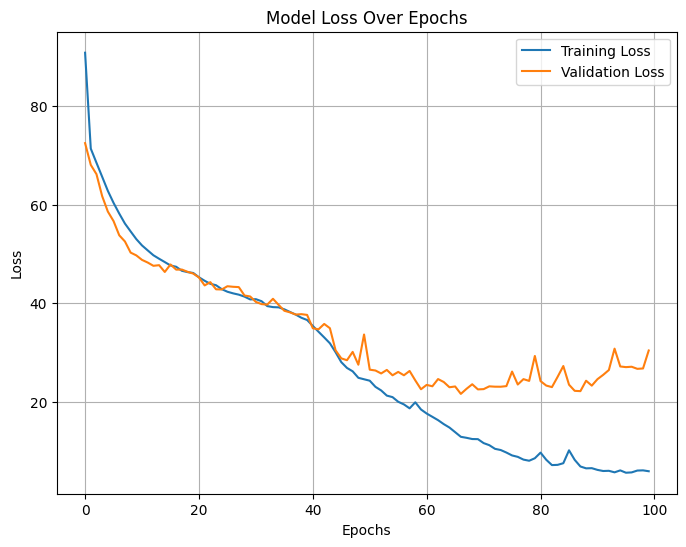

In [41]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [42]:
sample = load_data(tf.convert_to_tensor('/kaggle/input/data/s1_processed/bbal7s.mpg'))

In [43]:
sample[0].shape

TensorShape([75, 46, 140, 1])

In [44]:
sample[1]

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([ 2,  9, 14, 30,  2, 12, 21,  5, 30,  1, 20, 30, 12, 30, 19,  5, 22,
        5, 14, 30, 19, 15, 15, 14])>

In [45]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l seven soon'>]

In [46]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


In [47]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [48]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at z seven soon'>]